# Install Library

In [1]:
!pip install timm seaborn tqdm


# Import Library

In [2]:
#import library
import os
import pandas as pd
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm


# Import library PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import timm

# Cek  GPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU terdeteksi:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("GPU tidak tersedia, menggunakan CPU")

device

GPU terdeteksi: Tesla T4


device(type='cuda')

# Load dataset & encode label

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
   filename      label
0  0001.jpg  gado_gado
1  0002.jpg  gado_gado
2  0003.jpg    rendang
3  0004.jpg      bakso
4  0005.jpg      bakso


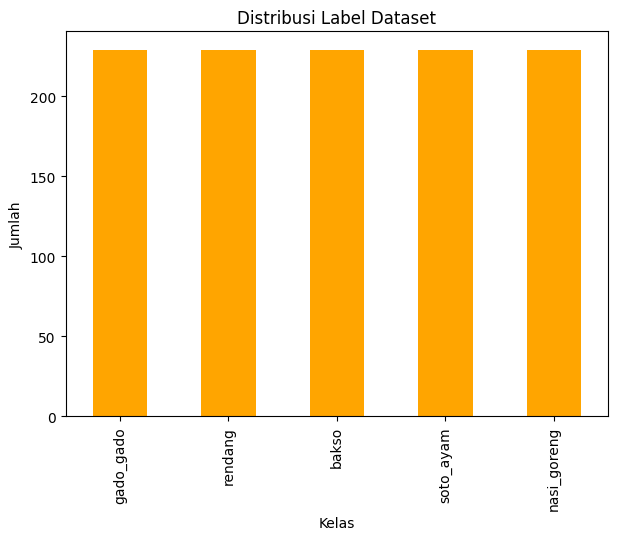

Jumlah Data Train: 916
Jumlah Data Validasi: 229
Persentase Data Train     : 80.00%
Persentase Data Validasi  : 20.00%


5

In [3]:
#memasukkan data dan label
from google.colab import drive
drive.mount('/content/drive')

csv_path = "/content/drive/MyDrive/labels.csv"
img_dir  = "/content/drive/MyDrive/datasett/dataset"
df = pd.read_csv(csv_path)
print(df.head())

# Visualisasi distribusi kelas dataset
plt.figure(figsize=(7,5))
df['label'].value_counts().plot(kind='bar', color='orange')
plt.title("Distribusi Label Dataset")
plt.xlabel("Kelas")
plt.ylabel("Jumlah")
plt.show()

# Encode label
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])

# Split train dan validation
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df['label_encoded']
)

print("Jumlah Data Train:", len(train_df))
print("Jumlah Data Validasi:", len(val_df))

# Hitung persentase
total = len(df)
train_percent = (len(train_df) / total) * 100
val_percent   = (len(val_df) / total) * 100

print(f"Persentase Data Train     : {train_percent:.2f}%")
print(f"Persentase Data Validasi  : {val_percent:.2f}%")

num_classes = len(label_encoder.classes_)
num_classes


# Class Dataset dan Augmentasi

In [4]:
# Class dataset custom untuk membaca gambar & label
class FoodDataset(Dataset):
    # Dataset ini menerima dataframe, folder gambar, dan transformasi
    def __init__(self, df, img_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    # Mengambil satu data: gambar + label
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row['filename'])

        # Baca gambar sebagai RGB (untuk model transformer)
        image = Image.open(img_path).convert("RGB")
        label = row['label_encoded']

        # Jika ada augmentasi maka terapkan
        if self.transform:
            image = self.transform(image)

        return image, label


# Augmentasi untuk training
train_tf = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])

# Transformasi validasi (tanpa augmentasi)
val_tf = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])

# Membuat dataset & loader
train_ds = FoodDataset(train_df, img_dir, train_tf)
val_ds   = FoodDataset(val_df, img_dir, val_tf)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=16, shuffle=False)


# Konfigurasi training

In [5]:
# hyper parameter yang dibutuhkan
config = {
    "epochs": 12,
    "lr": 1e-4,
    "batch_size": 16,
    "patience": 3, # untuk early stopping
    "device": device,
    "save_path": "/content/drive/MyDrive/ResultDL"
}

# Membuat folder hasil jika belum ada
os.makedirs(config["save_path"], exist_ok=True)

config


{'epochs': 12,
 'lr': 0.0001,
 'batch_size': 16,
 'patience': 3,
 'device': device(type='cuda'),
 'save_path': '/content/drive/MyDrive/ResultDL'}

# Load Model

In [6]:
#import library yang belum
import timm
import torch.nn as nn

# fungsi untuk parameter
def count_params(model):
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total = sum(p.numel() for p in model.parameters())
    return trainable, total
model_swin = timm.create_model(
    "swin_tiny_patch4_window7_224",
    pretrained=True,
    num_classes=num_classes
)
for param in model_swin.parameters():
    param.requires_grad = False


# 1. MLP HEAD / classifier
for name, param in model_swin.head.named_parameters():
    param.requires_grad = True

# 2. FINAL LAYERNORM
for name, param in model_swin.norm.named_parameters():
    param.requires_grad = True

# 3. HANYA 1 BLOCK TERAKHIR dari layer 4
last_layer = model_swin.layers[3]

for name, param in last_layer.blocks[-1].named_parameters():  # block terakhir saja
    param.requires_grad = True


# Print hasil trainable
print("Trainable Swin Tiny (MLP + 1 block terakhir)")
print(count_params(model_swin))


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Trainable Swin Tiny (MLP + 1 block terakhir)
(7097309, 27523199)


# Fungsi Training dan early stopping

In [7]:
#Persiapan Model dan Optimizer
def train_model(model, train_loader, val_loader, config, model_name):
    model.to(config["device"])

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=config["lr"]
    )
    #Inisialisasi Variabel
    best_loss = float("inf")
    patience_counter = 0

    history = {
        "train_loss": [], "val_loss": [],
        "train_acc": [], "val_acc": []
    }
  #Loop Training per Epoch
    for epoch in range(config["epochs"]):
        model.train()
        train_loss, correct_train = 0, 0

        for x, y in train_loader:
            x, y = x.to(config["device"]), y.to(config["device"])

            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            correct_train += (outputs.argmax(1) == y).sum().item()

        train_loss /= len(train_loader)
        train_acc = correct_train / len(train_loader.dataset)

        # Validation
        model.eval()
        val_loss, correct_val = 0, 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(config["device"]), y.to(config["device"])
                outputs = model(x)
                val_loss += criterion(outputs, y).item()
                correct_val += (outputs.argmax(1) == y).sum().item()

        val_loss /= len(val_loader)
        val_acc = correct_val / len(val_loader.dataset)

        # Simpan history
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        print(f"[{model_name}] Epoch {epoch+1}/{config['epochs']} "
              f"TrainLoss={train_loss:.4f} ValLoss={val_loss:.4f} "
              f"TrainAcc={train_acc:.4f} ValAcc={val_acc:.4f}")

        #  SIMPAN MODEL TERBAIK
        if val_loss < best_loss:
            best_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), f"{config['save_path']}/{model_name}_best.pth")
            print(f"Model terbaik {model_name} disimpan!")
        else:
            patience_counter += 1

        if patience_counter >= config["patience"]:
            print("Early stopping aktif!")
            break

    return model, history


# Training Model

In [8]:
history_dict = {}
model_swin, hist_swin = train_model(model_swin, train_loader, val_loader, config, "swin")
history_dict["swin"] = hist_swin

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[swin] Epoch 1/12 TrainLoss=0.7879 ValLoss=0.2605 TrainAcc=0.7576 ValAcc=0.9214
Model terbaik swin disimpan!
[swin] Epoch 2/12 TrainLoss=0.2053 ValLoss=0.0954 TrainAcc=0.9509 ValAcc=0.9738
Model terbaik swin disimpan!
[swin] Epoch 3/12 TrainLoss=0.1222 ValLoss=0.0672 TrainAcc=0.9738 ValAcc=0.9782
Model terbaik swin disimpan!
[swin] Epoch 4/12 TrainLoss=0.1156 ValLoss=0.0448 TrainAcc=0.9749 ValAcc=0.9825
Model terbaik swin disimpan!
[swin] Epoch 5/12 TrainLoss=0.0862 ValLoss=0.0655 TrainAcc=0.9738 ValAcc=0.9782
[swin] Epoch 6/12 TrainLoss=0.0641 ValLoss=0.0584 TrainAcc=0.9825 ValAcc=0.9782
[swin] Epoch 7/12 TrainLoss=0.0529 ValLoss=0.0657 TrainAcc=0.9869 ValAcc=0.9825
Early stopping aktif!


# Plot Kurva

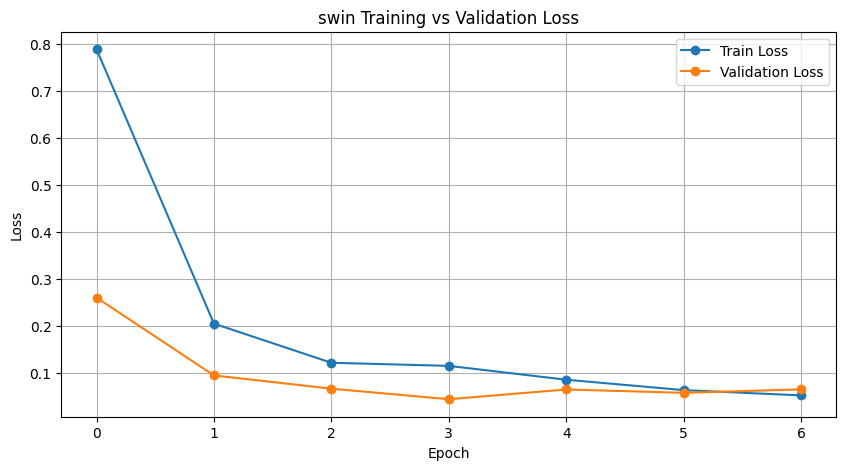

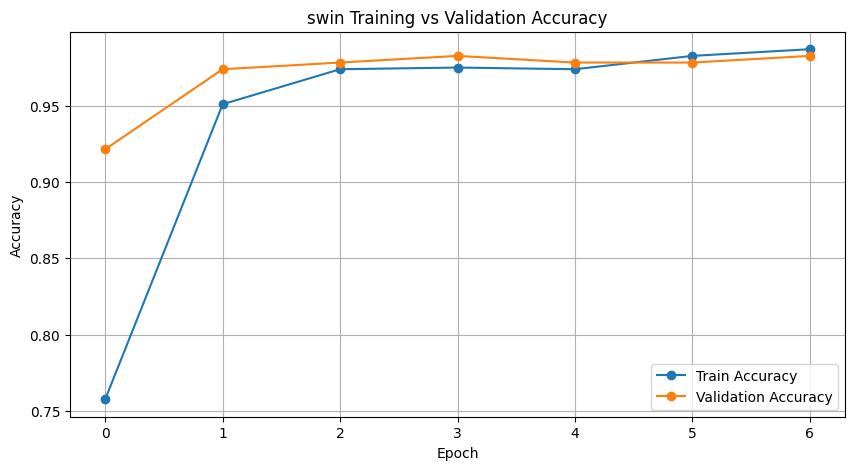

In [9]:
hist = history_dict["swin"]
#  Plot Loss Curve CaiT
plt.figure(figsize=(10,5))
plt.plot(hist["train_loss"], label="Train Loss", marker='o')
plt.plot(hist["val_loss"], label="Validation Loss", marker='o')
plt.title("swin Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()

#  Plot Accuracy Curve CaiT
plt.figure(figsize=(10,5))
plt.plot(hist["train_acc"], label="Train Accuracy", marker='o')
plt.plot(hist["val_acc"], label="Validation Accuracy", marker='o')
plt.title("swin Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.show()


# Evaluasi

Evaluating swin: 100%|██████████| 15/15 [00:07<00:00,  1.99it/s]



 swin
              precision    recall  f1-score   support

       bakso       0.96      1.00      0.98        46
   gado_gado       0.98      1.00      0.99        45
 nasi_goreng       0.98      0.98      0.98        46
     rendang       1.00      0.96      0.98        46
   soto_ayam       1.00      0.98      0.99        46

    accuracy                           0.98       229
   macro avg       0.98      0.98      0.98       229
weighted avg       0.98      0.98      0.98       229



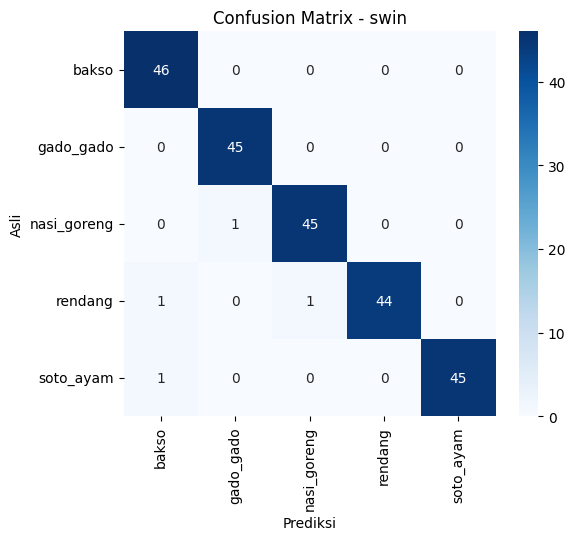

In [10]:
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm

def evaluate_model(model, model_name):
    preds, trues = [], []
    model.eval()

    # Progress bar saat evaluasi
    with torch.no_grad():
        for x, y in tqdm(val_loader, desc=f"Evaluating {model_name}", leave=True):
            x = x.to(device)
            out = model(x)

            preds.extend(out.argmax(1).cpu().numpy())
            trues.extend(y.numpy())

    # Menampilkan Classification Report
    print(f"\n {model_name}")
    print(classification_report(
        trues, preds,
        target_names=label_encoder.classes_
    ))

    # Menghitung Confusion Matrix
    cm = confusion_matrix(trues, preds)

    # Visualisasi Confusion Matrix
    plt.figure(figsize=(6,5))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=label_encoder.classes_,
        yticklabels=label_encoder.classes_
    )
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Prediksi")
    plt.ylabel("Asli")
    plt.show()
evaluate_model(model_swin, "swin")


In [11]:
def measure_inference_time(model, model_name, test_loader, num_warmup=10, num_test=200):
    """
    Mengukur waktu inferensi model

    Args:
        model: Model yang akan diukur
        model_name: Nama model (untuk display)
        test_loader: DataLoader untuk testing
        num_warmup: Jumlah batch untuk warmup GPU
        num_test: Jumlah gambar yang akan diukur
    """
    model.eval()

    print(f"\n{'='*50}")
    print(f"INFERENCE TIME MEASUREMENT - {model_name}")
    print(f"{'='*50}")

    # 1. WARMUP (penting untuk GPU agar stabil)
    print(f"Warming up GPU dengan {num_warmup} batch...")
    with torch.no_grad():
        for i, (images, _) in enumerate(test_loader):
            if i >= num_warmup:
                break
            images = images.to(device)
            _ = model(images)

    # 2. PENGUKURAN WAKTU
    times = []
    total_images = 0

    print(f"Mengukur waktu inferensi untuk {num_test} gambar...")
    with torch.no_grad():
        for images, _ in tqdm(test_loader, desc="Measuring", leave=False):
            if total_images >= num_test:
                break

            images = images.to(device)
            batch_size = images.size(0)

            # Mulai timer
            start_time = time.time()

            # Inferensi
            _ = model(images)

            # Sinkronisasi GPU (penting!)
            if torch.cuda.is_available():
                torch.cuda.synchronize()

            # Stop timer
            end_time = time.time()

            # Hitung waktu per gambar
            batch_time = (end_time - start_time) / batch_size
            times.append(batch_time)
            total_images += batch_size

    # 3. HITUNG STATISTIK
    times = np.array(times)
    avg_time_sec = np.mean(times)
    std_time_sec = np.std(times)
    avg_time_ms = avg_time_sec * 1000
    std_time_ms = std_time_sec * 1000
    throughput = 1.0 / avg_time_sec  # gambar per detik

    # Hitung waktu untuk seluruh test set
    total_test_images = len(test_loader.dataset)
    total_time_sec = avg_time_sec * total_test_images

    # 4. HARDWARE INFO
    if torch.cuda.is_available():
        gpu_name = torch.cuda.get_device_name(0)
        gpu_memory = torch.cuda.get_device_properties(0).total_memory / (1024**3)
        hardware = f"GPU: {gpu_name} ({gpu_memory:.1f} GB)"
    else:
        import platform
        hardware = f"CPU: {platform.processor()}"

    # 5. TAMPILKAN HASIL
    print(f"\n HASIL PENGUKURAN:")
    print(f"{'─'*50}")
    print(f"Hardware              : {hardware}")
    print(f"Jumlah gambar diukur  : {total_images}")
    print(f"{'─'*50}")
    print(f"  Waktu per gambar    : {avg_time_ms:.2f} ± {std_time_ms:.2f} ms")
    print(f" Throughput          : {throughput:.2f} gambar/detik")
    print(f" Waktu total test set: {total_time_sec:.2f} detik ({total_test_images} gambar)")
    print(f"{'='*50}\n")

    # 6. RETURN DICTIONARY
    return {
        'model_name': model_name,
        'hardware': hardware,
        'avg_time_ms': avg_time_ms,
        'std_time_ms': std_time_ms,
        'avg_time_sec': avg_time_sec,
        'throughput': throughput,
        'total_test_time_sec': total_time_sec,
        'total_images_measured': total_images,
        'total_test_images': total_test_images
    }

# GUNAKAN FUNGSI
inference_results_swin = measure_inference_time(
    model=model_swin,
    model_name="Swin Transformer",
    test_loader=val_loader,  # atau test_loader
    num_warmup=10,
    num_test=200
)


INFERENCE TIME MEASUREMENT - Swin Transformer
Warming up GPU dengan 10 batch...
Mengukur waktu inferensi untuk 200 gambar...



 HASIL PENGUKURAN:
──────────────────────────────────────────────────
Hardware              : GPU: Tesla T4 (14.7 GB)
Jumlah gambar diukur  : 208
──────────────────────────────────────────────────
  Waktu per gambar    : 5.19 ± 0.35 ms
 Throughput          : 192.65 gambar/detik
 Waktu total test set: 1.19 detik (229 gambar)

